# 残差网络（ResNet）
随着设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。

更重要的
是设计网络的能力，在这种网络中，添加层会使网络更具表现力，为了取得质的突破，我们需要一些数学基
础知识。

## 函数类

首先，假设有一类特定的神经网络架构 $\mathcal{F}$，它包括学习速率和其他超参数设置。对于所有的 $f \in \mathcal{F}$ ，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得。现在假设 $f^{*}$ 使我们真正想要找到的函数，如果 $f^{*} \in \mathcal{F}$ ，那我们可以轻而易举的训练得到它。但通常我们不会这么幸运。相反，我们将尝试找到一个函数 $f_{\mathcal{F}}^{*}$ ，这是我们在 $\mathcal{F}$ 中的最佳选择。例如，给定一个具有 $\mathbf{X}$ 特性和 $\mathbf{y}$ 标签的数据集，我们可以尝试通过解决一下优化问题来找到它：
$$
    f_{\mathcal{F}}^{*} := \underset{f}{argmin} L(\mathbf{X}, \mathbf{y}, f) \quad subject \quad to \quad f \in \mathcal{F}.
$$

那么，怎样得到更近似真正的 $f^{*}$ 的函数呢？唯一合理的可能性是，我们需要设计一个更强大的架构 $\mathcal{F}'$。换句话说，我们预计 $f_{\mathcal{F}'}^{*}$ 比 $f_{\mathcal{F}}^{*}$ “更近似”。然而，如果 $\mathcal{F} \not\subseteq \mathcal{F}'$ ，则无法保证新的体系“更近似”。事实上， $f_{\mathcal{F}'}^{*}$ 可能会更糟：如图所示：

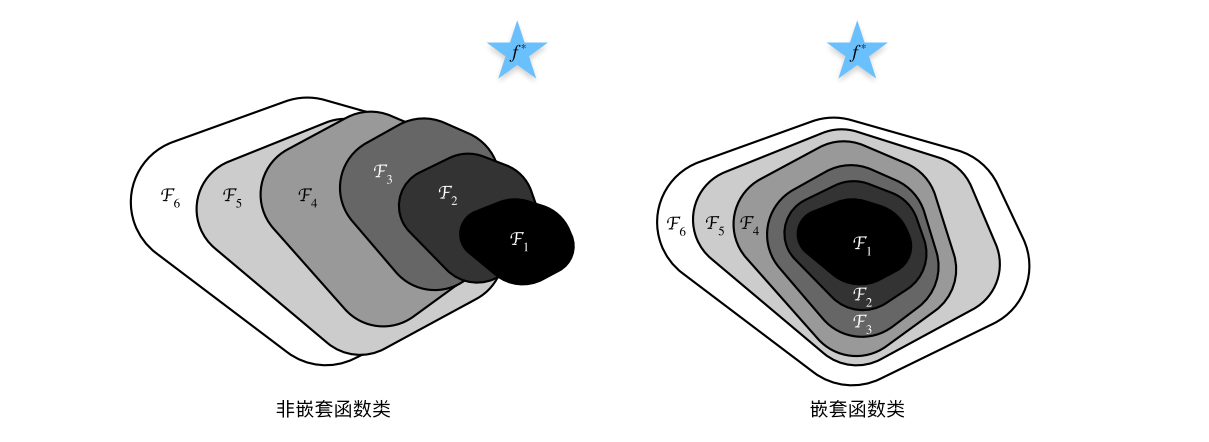

对于非嵌套函数（non‐nested function）类，较复杂的函数类并不总是向“真”函数 $f^*$ 靠拢
（复杂度由F1向F6递增）。

在上图的左边，虽然 $\mathcal{F}_3$ 比 $\mathcal{F}_1$ 更接近 $f^{*}$，但是 $\mathcal{F}_6$ 却离得更远了。对于右边的嵌套函数，就没有这个问题。

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。对于深度神经网络，如
果我们能将新添加的层训练成恒等映射（identity function） $f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。

由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

`残差网络的核心思想是：`每个附加层都应该更容易地
包含原始函数作为其元素之一。

于是，残差块（residual blocks）便诞生了，这个设计对如何建立深层神经
网络产生了深远的影响。凭借它，ResNet赢得了2015年ImageNet大规模视觉识别挑战赛。

## 残差块
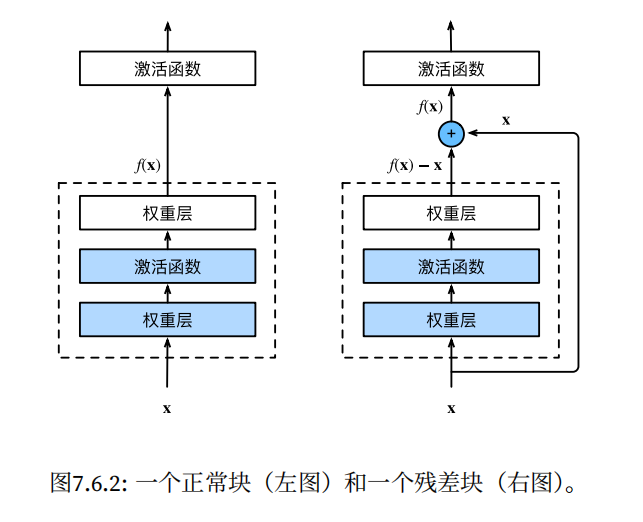

左图虚线框中的部分需要直接拟合出该映射 $f(x)$ ，而右图虚线框中
的部分则需要拟合出残差映射 $f(x) - x$ 。残差映射在现实中往往更容易优化。

恒等映射作
为我们希望学出的理想映射 $f(x)$ ，我们只需将右图虚线框内上方的加权运算（如仿射）的权重和偏
置参数设成0，那么 $f(x)$ 即为恒等映射。

ResNet沿用了VGG完整的3 × 3卷积层设计。残差块里首先有2个有相同输出通道数的3 × 3卷积层。每个卷积
层后接一个批量规范化层和ReLU激活函数。

然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接
加在最后的ReLU激活函数前。

这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。

如果想改变通道数，就需要引入一个额外的1 × 1卷积层来将输入变换成需要的形状后再做相加运算。残差块的实现如下：

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, 
                    use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, 
                                kernel_size=3, padding=1, stride = strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, 
                                kernel_size = 3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, 
                                    kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

如图所示，此代码生成两种类型的网络：一种是当use_1x1conv=False时，应用ReLU非线性函数之前，将输入添加到输出。另一种是当use_1x1conv=True时，添加通过1x1卷积调整通道和分辨率。

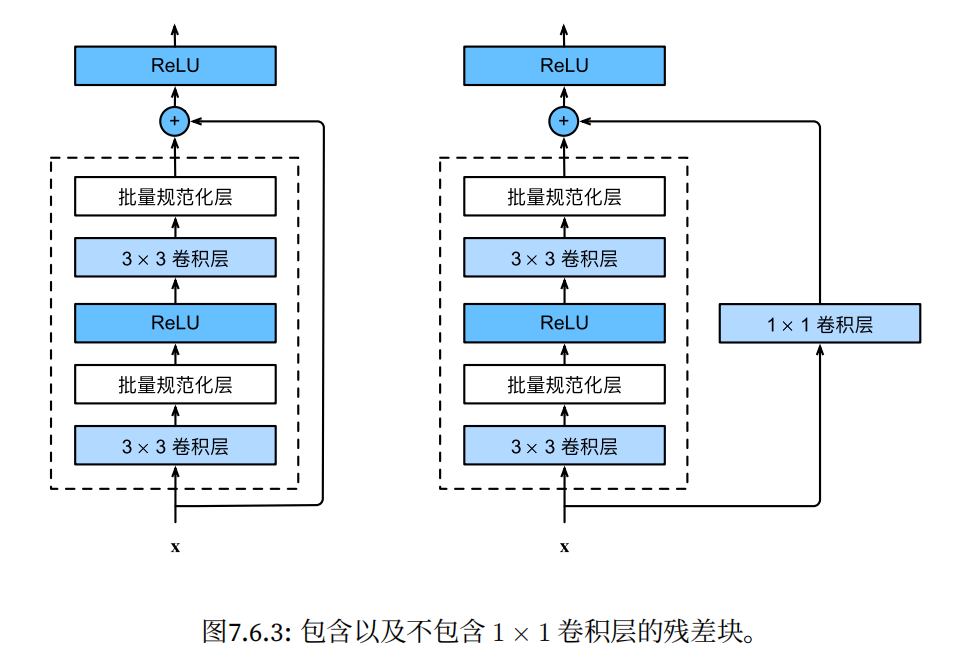

查看输入和输出形状一致的情况。

In [4]:
blk = Residual(3,3)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在增加输出通道数的同时，减半输出的高和宽。

In [5]:
blk = Residual(3,6,use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet模型
ResNet的前两层跟之前介绍的GoogLeNet中的一样：在输出通道数为64、步幅为2的7 × 7卷积层后，接步幅
为2的3 × 3的最大汇聚层。不同之处在于ResNet每个卷积层后增加了批量规范化层。

In [10]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

ResNet则使用4个由残差块组成的模块，每个模块使用
若干个同样输出通道数的残差块。

第一个模块的通道数同输入通道数一致。由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [11]:
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet加入所有的残差块，这里每个模块使用2个残差块。

In [12]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。

In [13]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1, 1)),
                    nn.Flatten(), nn.Linear(512, 10))

在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。在之前所有架构中，分辨
率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

In [14]:
X = torch.rand(size=(1,1,224,224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


### 训练模型

loss 0.009, train acc 0.998, test acc 0.916
2600.1 examples/sec on cuda:0


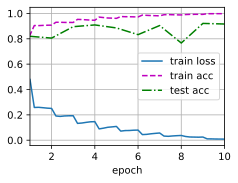

In [15]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())